In this notebook, I will use torch_geometric to predict the developpement of a graph of positions through time

In [1]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F

import numpy as np

import torch_geometric
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.nn import radius_graph
from torch_geometric.data import Data

import networkx as nx

import pickle

import time

import sys
import os
from genericpath import exists

import random

sys.path.append('/home/nstillman/1_sbi_activematter/cpp_model')
import allium

model_path = "model.pkl"
loss_path = "loss.pkl"

from cell_dataset import CellGraphDataset
from cell_model import GraphEvolution

import threading
import matplotlib.pyplot as plt

import os, psutil
process = psutil.Process(os.getpid())
print("Using : ", process.memory_info().rss // 1000000)  # in megabytes 
print("Available : ", process.memory_info().vms  // 1000000)  # in megabytes 

print(torch.cuda.is_available())

No module named 'pycapmd'
Cannot import simulator
Using :  431
Available :  3585
True


The data is a graph of cells having their own positions and velocity.

In the graph, we will first start by connecting all the edges, then maybe later make radius_graphs to reduce the cost of the pass through the model

In [2]:
#path = "data/" #local
path = "/scratch/users/nstillman/data-cpp/" #remote

data_train = CellGraphDataset(root=path + 'train', max_size=200, rdts=True, inmemory=True, bg_load=True)
print("Training data length : ", data_train.len())

data_test = CellGraphDataset(root=path + 'test', max_size=50, inmemory=True, bg_load=True)
print("Test data length : ", data_test.len())
 
data_val = CellGraphDataset(root=path + 'valid', max_size=50, inmemory=True, bg_load=True)
print("Validation data length : ", data_val.len())

Training data length :  200
Test data length :  50
Validation data length :  50


In [3]:
if "sources" not in os.listdir():
    os.mkdir("sources")
    
override = True #make this true to always use the same ones
if override :
    if "train_paths.pkl" not in os.listdir("sources"):
        #first time running, dump the paths to a pickle file
        data_train.dump_source("sources/train_paths.pkl")
    else :
        #overwrite the paths to the previous configuration
        data_train.overwrite_source("sources/train_paths.pkl")

    if "test_paths.pkl" not in os.listdir("sources"):
        data_test.dump_source("sources/test_paths.pkl")
    else :
        data_test.overwrite_source("sources/test_paths.pkl")

    if "val_paths.pkl" not in os.listdir("sources"):
        data_val.dump_source("sources/val_paths.pkl")
    else :
        data_val.overwrite_source("sources/val_paths.pkl")

In [4]:
rval, edge_index, edge_attr, batch_edge = data_train.get(0)
#print(rval, edge_index, edges_attr, batch_edge)

Next we need to define the model that will be used :
    > input 
        (1) Graph at a particular time t (nodes having x,y,dx,dy as attributes)
        (2) Graphs up to a particular time [t-a, t] (nodes having x,y as attributes)
    > output
        (a) Graph at the immediate next time step t+1
        (b) Graph [t, t+b]
        (c) Graph at t+b
    > graph size
        (x) Fixed graph size to the most nodes possible (or above)
        (y) Unbounded graph size
            >> idea : graph walks
            >> idea : sampler

The following model will do (1ax)

In [5]:
global losses
losses = []

def run_single(data, i, device) :
    x, edge_index, edge_attr, batch_edges = data.get(i)

    xshape = x.shape

    x = x.to(device)
    edge_index = edge_index.to(device)
    edge_attr = edge_attr.to(device)
    batch_edges = batch_edges.to(device)

    edge_index = edge_index - batch_edges * xshape[1]

    #we don't want to predict the last step since we wouldn't have the data for the loss
    #and for the first point we don't have the velocity
    mask = torch.logical_and(batch_edges > 0, \
                             batch_edges < xshape[0] - 1)
    out = model(x[1:-1], edge_index[:, mask] , edge_attr[mask])
    
    loss = F.mse_loss(out, x[2:])
    
    return loss

In [6]:
def test(model, data, device) :
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        loss_sum = 0
        for i in range(data.len()):
            loss = run_single(data, i, device)
            
            loss_sum = loss_sum + loss.item()
            
        return loss_sum / data.len()

In [7]:
def train(model, optimizer, scheduler, data, device, epoch) :
    model.train()
    model = model.to(device)
    for i in range(data.len()):
        optimizer.zero_grad()
        
        loss = run_single(data, i, device)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step(epoch + i / data.len())
        
        print("Current loss : " , loss.item(), " ... ", i, "/", data.len(), ". Current memory usage : ", process.memory_info().rss // 1000000, " MB, loaded ", len(data.memory), "    ", end="\r")  # in megabytes 
        
    return model

In [14]:
def start(model, optimizer, scheduler, data_train, data_test, device, epoch, offset, save=0, early_stop=False):
    for e in range(offset, offset + epoch):
        model = train(model, optimizer, scheduler, data_train, device, e)
            
        test_loss = test(model, data_test, device)
        
        print("Epoch : ", e, "Test loss : ", test_loss, "                                                         ")
        
        losses.append(test_loss)
        
        if early_stop and len(losses) > 30 :
            recent_losses = min(len(losses), 30)
            y = losses[-recent_losses:]
            
            axis = np.arange(recent_losses)
            A = np.vstack([axis, np.ones(len(axis))]).T
            
            a = np.linalg.lstsq(A, y, rcond=None)
            
            if a[0][0] >= -0.002 :
                print("Early stopping : recent slope at ", a[0][0])
                if (save) :
                    with open(model_path, 'wb') as f:
                        pickle.dump(model, f)
                return
            else : 
                print("Early stopping passed : current slope at ", a[0][0])
        
        if (save and (e%save == 0 or e == epoch-1)) :
            with open(model_path, 'wb') as f:
                pickle.dump(model, f)
            with open(loss_path, 'wb') as f:
                pickle.dump(losses, f)

In [9]:
load = True
if (load and exists(model_path)) :
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    with open(loss_path, 'rb') as f:
        losses = pickle.load(f)
else :
    model = GraphEvolution(4, 4, 32, 8, 0.0, edge_dim=len(data_train.attributes));
    
assert isinstance(model, GraphEvolution)
    
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, T_mult=2)

In [10]:
class GraphingLoss():
    def __init__(self):
        self.losses = []
        self.stop = False
        self.timer = 0
        self.last_len = 0
        self.fig = None
        self.ax = None

    def plot_and_reschedule(self):
        if not self.stop:
            if (self.last_len != len(losses)) :
                if self.fig is None :
                    self.fig = plt.figure()
                    self.ax = self.fig.add_subplot(111)
                
                self.ax.clear() # type: ignore
                self.ax.plot(losses) # type: ignore
                self.fig.show()
                self.fig.canvas.draw()
                self.last_len = len(losses)
                
                plt.savefig("Losses.pdf", format="pdf")

            threading.Timer(self.timer, self.plot_and_reschedule).start()
            
    def gstop(self):
        self.stop = True
        
    def gstart(self, timer=20):
        self.timer = timer
        if (not self.timer or self.timer != int(self.timer)):
            raise ValueError("timer must be a positive integer")
        
        threading.Timer(self.timer, self.plot_and_reschedule).start()

Epoch :  501 Test loss :  1.6410113921761513                                                                
Epoch :  502 Test loss :  1.6303067715466022                                                               
Epoch :  503 Test loss :  1.6345515128970147                                                                
Epoch :  504 Test loss :  1.6393278269469738                                                                
Epoch :  505 Test loss :  1.6319661018252374                                                               
Epoch :  506 Test loss :  1.6234690676629544                                                               
Epoch :  507 Test loss :  1.6036989143490792                                                               
Epoch :  508 Test loss :  1.6176071894168853                                                                
Epoch :  509 Test loss :  1.6734341506659984                                                               
Epoch :  510 Test loss :

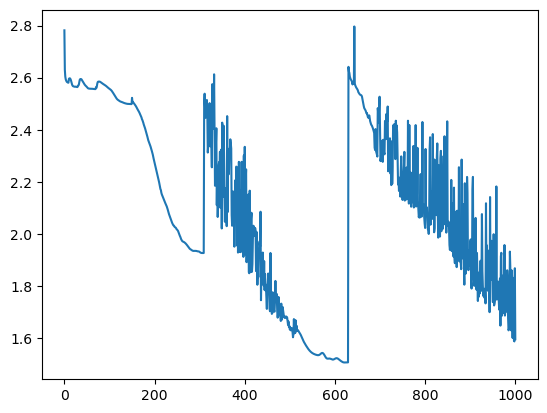

In [15]:
epochs = 501
grapher = GraphingLoss()
scheduler.step(len(losses))
try :
    grapher.gstart(20)
    start(model, optimizer, scheduler, data_train, data_test, "cuda" if torch.cuda.is_available() else "cpu", epochs, len(losses), save=50, early_stop = False)
finally :
    grapher.gstop()

In [17]:
#things to do :
    #normalize the inputs 
    #make sure this model doesn't use past times (normally should not since the graph is disconnected and it's based on message passing)
    #show the results